# Modeling-to-Generate-Alternatives (MGA) Tutorial

MGA is commonly used in energy modelling to address what is known as "structural uncertainty."
That is, the uncertainty stemming from unknown, unmodeled, or unmodel-able objectives. For instance,
political feasibility or some other qualitative variable.

## The MGA Idea

To get around this challenge, MGA searches the "sub-optimal" or "near-optimal" region for alternative
solutions by relaxing the objective function. The goal for a single-objective problem is to find 
"maximally different solutions in the design space." In multi-objective problems, specifically ones solved
with genetic algorithms, users can identify alternatives by random selection or farthest first traversal.

## MGA Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
# pymoo imports
from pymoo.problems import get_problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

from osier import n_mga
from osier import distance_matrix, farthest_first, check_if_interior, apply_slack

In [2]:
problem = get_problem("bnh")
seed = 45
pop_size = 100
n_gen = 200
algorithm = NSGA2(pop_size=pop_size)

res = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               seed=seed,
               verbose=False,
               save_history=True
               )


In [3]:
PF = problem.pareto_front()
F = res.F
a = min(F[:,0])
b = max(F[:,0])
f1 = PF[:,0]
f2 = PF[:,1]
slack = 0.1
alpha = 0.5
F1 = f1 * (1+slack)
F2 = f2 * (1+slack)

In [4]:
X_hist = np.array([history.pop.get("X") for history in res.history]).reshape(n_gen*pop_size,2)
F_hist = np.array([history.pop.get("F") for history in res.history]).reshape(n_gen*pop_size,2)

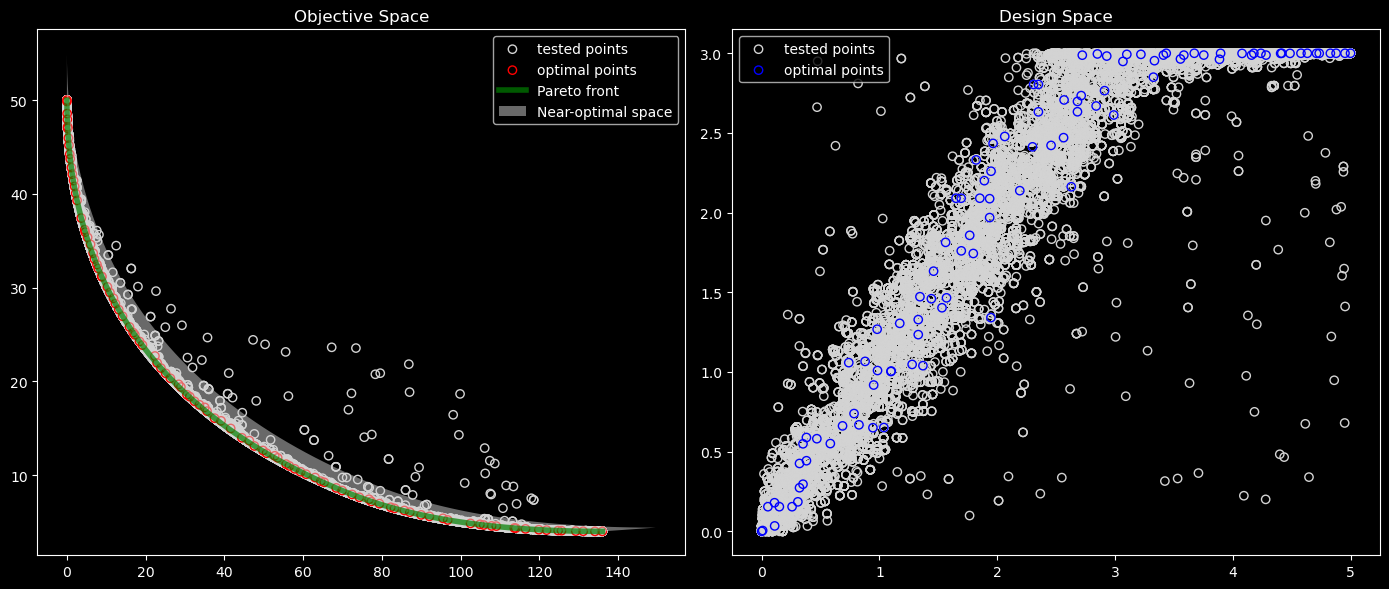

In [5]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,2, figsize=(14,6))

    ax[0].set_title("Objective Space")
    ax[0].scatter(F_hist[:,0], F_hist[:,1], facecolor="none", edgecolor="lightgray", label='tested points')
    ax[0].scatter(F[:,0], F[:,1], facecolor="none", edgecolor="red", label='optimal points')
    ax[0].plot(PF[:,0], PF[:,1], color="g", alpha=0.7, label='Pareto front', lw=4)
    ax[0].fill(np.append(f1, F1[::-1]), np.append(f2, F2[::-1]), 'lightgrey', alpha=alpha, label="Near-optimal space")
    ax[0].legend()


    ax[1].set_title("Design Space")
    ax[1].scatter(X_hist[:,0], X_hist[:,1], facecolor="none", edgecolor="lightgray", label='tested points')
    ax[1].scatter(res.X[:,0], res.X[:,1], facecolor="none", edgecolor="blue", label='optimal points')
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

### Create the slack front

In [6]:
slack_front = apply_slack(F, slack=slack)

### Check for points that are bounded within the Pareto front and the slacked front

In [7]:
int_pts = check_if_interior(points=F_hist, par_front=F, slack_front=slack_front)
X_int = X_hist[int_pts]
F_int = F_hist[int_pts]

### Create a distance matrix

This matrix stores the distances from one point to every other point.

In [8]:
D = distance_matrix(X=X_int)

### Calculate the farthest points

In [9]:
n_pts = 10
idxs = farthest_first(X=X_int, D=D, n_points=n_pts, seed=seed)

In [10]:
F_select = F_int[idxs]
X_select = X_int[idxs]

### Plot!

The objective space plot (left) shows the selected points in objective space. These points were chosen using a "farthest first traversal" in design space. The design space plot illustrates the path of this traversal. 

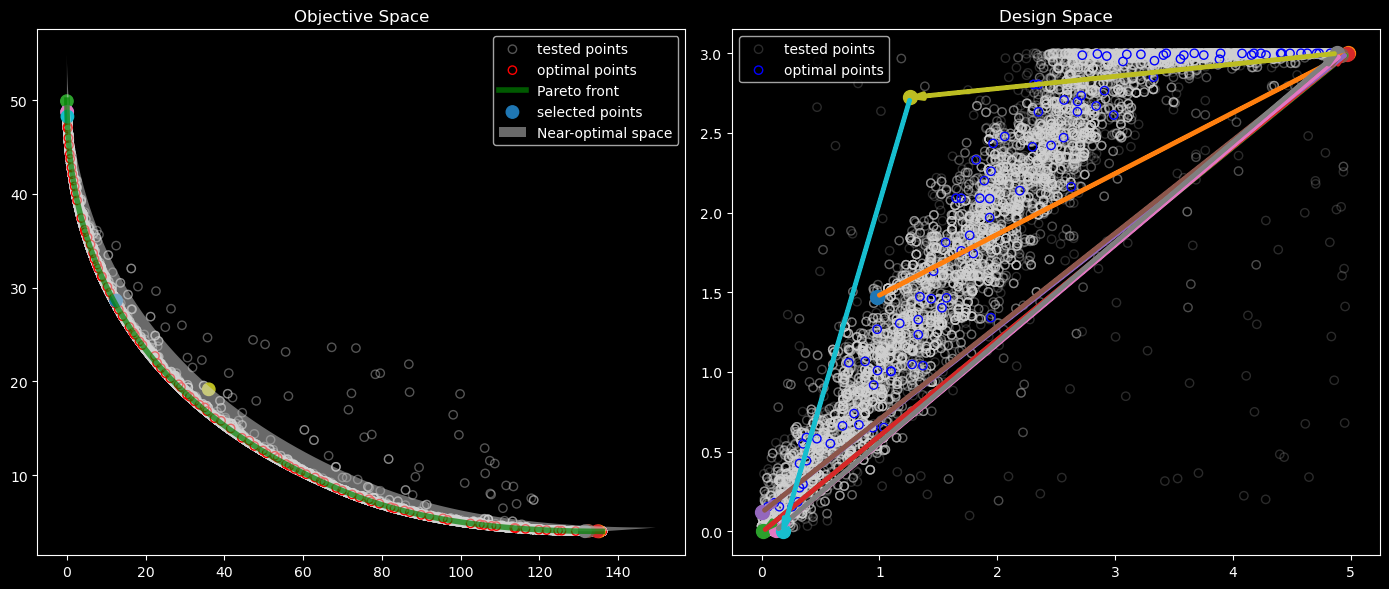

In [11]:
from mycolorpy import colorlist as mcp
import matplotlib as mpl
import matplotlib.patches as patches

cmap_name = 'tab10'
color1=mcp.gen_color(cmap=cmap_name,n=n_pts)
cmap = plt.get_cmap(cmap_name, n_pts)

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,2, figsize=(14,6))

    ax[0].set_title("Objective Space")
    ax[0].scatter(F_hist[:,0], F_hist[:,1], facecolor="none", edgecolor="lightgray", alpha=0.4,label='tested points')
    ax[0].scatter(res.F[:,0], res.F[:,1], facecolor="none", edgecolor="red", label='optimal points')
    ax[0].plot(PF[:,0], PF[:,1], color="g", alpha=0.7, label='Pareto front', lw=4)
    ax[0].scatter(F_select[:,0], F_select[:,1], c=color1, s=80, label='selected points')

    ax[0].fill(np.append(f1, F1[::-1]), np.append(f2, F2[::-1]), 'lightgrey', alpha=alpha, label="Near-optimal space")
    ax[0].legend()


    ax[1].set_title("Design Space")
    ax[1].scatter(X_hist[:,0], X_hist[:,1], facecolor="none", edgecolor="lightgray", alpha=0.2, label='tested points')
    ax[1].scatter(res.X[:,0], res.X[:,1], facecolor="none", edgecolor="blue", label='optimal points')
    ax[1].legend(loc='upper left')

    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    arrows = []
    prev = X_select[0]
    for i, (c, (x, y)) in enumerate(zip(color1,X_select)):
        ax[1].scatter(x, y, color=c, s=100)
        if i == 0:
            pass
        else:
            kw = dict(arrowstyle=style, color=c, linewidth=3)
            curr = (x,y)
            arrows.append(patches.FancyArrowPatch(prev, curr, **kw))
            prev = curr

    for a in arrows:
        ax[1].add_patch(a)

    plt.tight_layout()
    plt.show()

In [12]:
F_df = pd.DataFrame(dict(zip(['f0','f1'], F_select.T)))
X_df = pd.DataFrame(dict(zip(['x0','x1'], X_select.T)))
mga_df = pd.concat([F_df, X_df], axis=1)

# MGA with Osier

The MGA algorithm has several steps. Fortunately, `osier` offers a self contained function `n_mga`.

In [13]:
mga_res = n_mga(results_obj=res, slack=slack, seed=seed, wide_form=True)

Confirm that the two methods are equivalent.

In [14]:
mga_df.equals(mga_res)

True